> ### EEE4423: Deep Learning Lab

# LAB \#9: Interpretation&Attention: Grad-CAM

<h4><div style="text-align: right"> Due date: 2023.05.04  </div> <br>
<div style="text-align: right"> Please upload your file @ yscec in the form of [ID_Name_Week9.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[Insert your ID HERE] [Insert your name HERE]</span> </h2>

In [85]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-03 15:39:34.006357


## Grad-CAM with pretrained model(AlexNet[2], VGGnet[3])

## Gradient-weighted Class Activation Mapping(Grad-CAM)[1]
>- A techinique for producing 'visual explanations' for decisions from a CNN-based models
>- Higlights the most important (discriminative) image regions related to the specific class
>- Making CNN-based models more transparent
>- Unlike in CAM, any architectural changes or retraining are not needed from any CNN-based networks

<img src="https://docs.google.com/uc?export=view&id=1fIcX1gPOSk1Q6tt4QHUpf0LvQYhb60gE" alt="no_image" style="width: 900px;"/>

### Framework of Grad-CAM
>- A generic version of Class Activation Map(CAM)
>- Using **gradient information** flowing into the last convolutional layer of the CNN to understanding the importance of each neuron for a decision
>- Compute a weighted sum of the feature maps of the last convolutional layer to produce CAM 
>>- Gradient of the score for class c, $y_c$, with respect to feature maps($A^k$) of the last convolutional layer, $\frac{\partial y^c}{\partial A^k}$
>>- These gradients are global-average-pooled to obtain the neuron importance weights ($\alpha_k^c$) : 
$\frac{1}{Z} \sum_{i}\sum_{j} \frac{\partial y^c}{\partial A_ij^k}$ <br>
>>- Grad-CAM mask produced with weighted combination of activation maps, followed by a ReLU: $L_{Grad-CAM}^c = ReLU(\sum_{k} \alpha_k^cA^k)$ 
>
> ++ **We don't use Guided Backpropagation in this part**

<img src="https://docs.google.com/uc?export=view&id=1fPgSB_Bq6PHAnSvtDBI25NYcSMNZmsqO" alt="no_image" style="width: 900px;"/>

In [86]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import cv2
import io
import requests
import os 
import copy

from PIL import Image
from collections import OrderedDict

%matplotlib inline

In [87]:
# For torchsummary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install torchsummary
    from torchsummary import summary
    pass

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [89]:
# hyper-parameters
image_size = 224
num_classes = 1000

### Model (Pre-trained models)

In [90]:
print('STEP 3: CREATE MODEL CLASS (Pre-trained models)')

STEP 3: CREATE MODEL CLASS (Pre-trained models)


#### 1.Write codes for the pretrained model (AlexNet and VGG-16) [2 points]
>- Hint: All learnable parameters' sizes of two models are in the 9th cell below <br>

#### 1.1 AlexNet [1 point]
>- Maxpooling after each convolutional layer
>- Use ReLU as an activation function
>- Dropout before the 1st and 2nd fully-connected layers

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv | 11 | 4 | 2 |
| MaxPool | 3 | 2 | 0 |
| 2nd Conv | 5 | 1 | 2 |
| MaxPool | 3 | 2 | 0 |
| 3rd Conv | 3 | 1 | 1 |
| 4th Conv | 3 | 1 | 1 |
| 5th Conv | 3 | 1 | 1 |
| MaxPool | 3 | 2 | 0 |



In [159]:
#Pre-trained AlexNet from model_zoo
pretrained_AlexNet = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}

class AlexNet_Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride, padding, maxpool = False):
        super(AlexNet_Block, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size = kernel_size, stride = stride,padding = padding),
            nn.ReLU(inplace = True)
        )
        
    def forward(self, x):
        x = self.features(x)
        return x
    
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #AlexNet_Block(192, 384, 3, 1, 1)
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #AlexNet_Block(384, 256, 3, 1, 1)
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #AlexNet_Block(256, 256, 3, 1, 1)
            nn.MaxPool2d(kernel_size=3, stride=2) #Last Maxpool layer
        ) #features 
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        ) #classifier
        
        #features와 classifier를 구분해 구현하였고, 이후 Grad-CAM에서도 이를 고려해 코드를 구현해주었다.

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#### 1.2 VGGnet-16 [1 point]
>- No batch normalization and initializtion of weights
>- Model configuration is in the dictionary '*cfg*'
>- Use ReLU as an activation function
>- Dropout before the 2nd and last fully-connected layers

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| Conv | 3 | 1 | 1 |
| MaxPool | 2 | 2 | 0 |



In [160]:
#Pre-trained VGGnet-16 from model_zoo
pretrained_vgg = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
 
class VGGnet(nn.Module):
    def __init__(self, features, num_classes=num_classes):
        super(VGGnet, self).__init__()
        
        self.features = features
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
       
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
  
    
    
    #features와 classifier를 구분해 구현하였고, 이후 Grad-CAM에서도 이를 고려해 코드를 구현해주었다.
                
def make_layers(cfg, batch_norm=False): #Vgg의 features 부분을 만들어주는 함수로, 이는 vgg class와 별도로 구현되어 있음을 주의한다.
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M': #Maxpool layer의 경우 M으로 표기되어 있으므로 이를 추가해준다.
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1) #kernel size 3짜리의 고정된 conv layer를 사용하는 것이 vgg의 특징이다.
            if batch_norm: #BatchNorm2d를 사용하는 경우 conv2d와 ReLU사이에 삽입해준다.
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

#### 2.Write codes for the model instantiation(AlexNet and VGG-16) [2 points]

In [161]:
print('STEP 4: INSTANTIATE MODEL CLASS')

# AlexNet
def alexnet(model, pretrained=False):
    if pretrained:
        model.load_state_dict(model_zoo.load_url(pretrained_AlexNet['alexnet']))
    return model

model_AlexNet = alexnet(AlexNet(), pretrained=True)


# VGG-16, no batch_norm
def vggnet(model, pretrained=False):
    if pretrained:
        model.load_state_dict(model_zoo.load_url(pretrained_vgg['vgg16']))
    return model

model_VGGnet = VGGnet(make_layers(cfg['D'], batch_norm=False))
model_VGGnet = vggnet(model_VGGnet, pretrained=True)

STEP 4: INSTANTIATE MODEL CLASS


In [162]:
print("AlexNet's Summary:")
model_AlexNet.to(device)
summary(model_AlexNet, (3, 224, 224))


print("\nVGGnet's Summary:")
model_VGGnet.to(device)
summary(model_VGGnet, (3, 224, 224))

AlexNet's Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14

### Grad-CAM mask generating and visualizing with given test images

In [163]:
#test images with ImageNet class number
test_list = (('./dataset-dllab/lab09/test_images/kingsnake.jpg', 56),
             ('./dataset-dllab/lab09/test_images/cat_dog.png', 243),
             ('./dataset-dllab/lab09/test_images/cat_dog.png', 282),
             ('./dataset-dllab/lab09/test_images/pizza.jpg', 963))

#imagenet class
imagenet_class = {56: 'king snake', 243: 'bull mastiff', 282: 'tiger cat', 963: 'pizza'}

#### Grad-CAM generator class 
#### 3.Write codes for the Grad-CAM generator class [6 points]
>- Use pre-trained models
>- Similar to CAM generator class
>- *save_gradient* : A backward hook function to save gradients w.r.t our target convolutional features
>>- Hook up this function to the target features in *forward_model* part of *GradCAM* class
>>- *register_hook()* is a function for tensor (e.g. itermediate features) 
>>- *register_backward_hook* is a function for module (e.g. nn.Conv2d) 
>>- References for hook function: [4],[5]<br>
>- *forward_model* : Forward pass of our pretrained model to produce the score of class($y^c$) and activation maps($A^k$)
>- *gen_CAM* : Generating Grad-CAM mask with two inputs(*img*: input image, *one_hot_target*: one-hot-class of image)
>>1. Produce feature maps and the score of class
>>2. Computing gradient of the score for class with respect to the feature maps of the last convolutional layer
>>>- Backward pass with *one_hot_target* input
>>3. Global averaging of the gradients to obtain the weights
>>4. Grad-CAM mask generating (weighted sum of the feature maps)
>>5. Resizing the mask to the input image's size
>>>- *cv2.resize* function or other functions 
>>6. ReLU to obtain a final mask 
>>7. min-max normalization of mask for visualizing
>
>++ **The feature maps (activations) are the intermediate results of network before last pooling layer like the ones in CAM**



In [164]:
class GradCAM():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.forward_result = 0
        self.backward_result = 0
        
    # A backward hook function to save gradients(weights for visualizing)
    def save_gradient(self, _, grad_input, grad):
        self.backward_result = torch.squeeze(grad[0]) #gradient를 구하는 코드이며 이후 register_backward_hook을 통해 model에 hook으로 붙게 된다.
    
    
    def forward_model(self,x):
        #코드 구현에 따라 input으로 받는 x가 다양해 질 수 있다는 생각이 들었다.
        #내 경우 이 때의 x는 img라고 가정하고 이 코드를 작성하였다.
        for modue_name, module in self.model._modules.items():
            if modue_name == 'features': #미리 모델에서 features라고 정의해 두었고, 이를 하드코딩 하였다.
                feature = list(module._modules.items()) #indexing을 위해 odict -> list로 type casting을 해준다.
                i_module = feature[-1][1] #feature의 마지막 부분
                i_module.register_backward_hook(self.save_gradient)
        
        self.forward_result = torch.squeeze(self.model.features(x)) #register_forward_hook을 통해 등록할 수 있지만, 현재 forward_hook함수가 구현되어 있지 않아 이런 방식으로 forward_result를 구하였다.
        
        
    def gen_CAM(self, img, one_hot_target):
        self.forward_model(img)
        outs = self.model(img)
        outs = outs.squeeze()
        
        outs[one_hot_target[0].bool()].backward(retain_graph=True)
        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)        
        out = torch.sum(a_k * self.forward_result, dim=0).cpu()               
        out = torch.relu(out) / torch.max(out) 
        out = F.upsample_bilinear(out.unsqueeze(0).unsqueeze(0), [224, 224])
        return out.cpu().detach().squeeze().numpy()        

In [165]:
# image array to image tensor
def preprocess_image(img, resize_img=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    if resize_img:
        img = img.resize((224,224))
    img_arr = np.float32(img)
    img_arr = img_arr.transpose(2, 0, 1) 

    for c, _ in enumerate(img_arr):
        img_arr[c] /= 255
        img_arr[c] -= mean[c]
        img_arr[c] /= std[c]

    img_tensor = torch.from_numpy(img_arr).float()
    img_tensor = torch.unsqueeze(img_tensor,0)
    
    return img_tensor

#image tensor to image array
def reprocess_image(img):
    img = torch.squeeze(img,0)
    mean = [-0.485, -0.456, -0.406]
    std = [1/0.229, 1/0.224, 1/0.225]
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    for c in range(3):
        img_re[c] /= std[c]
        img_re[c] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    img_re = np.round(img_re * 255)

    img_re = np.uint8(img_re).transpose(1, 2, 0)
    
    return img_re

#### Grad_CAM Visulaization with given test images


#### 1. AlexNet 


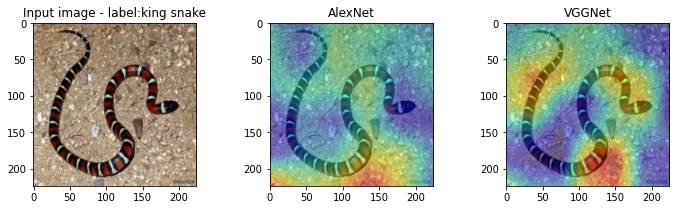

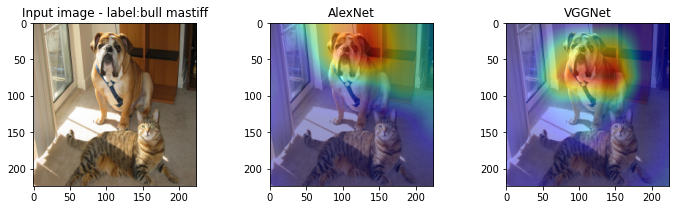

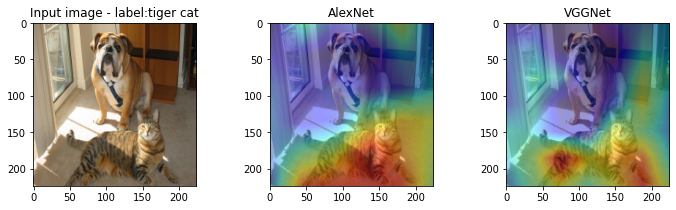

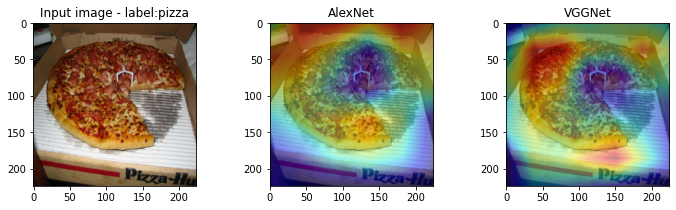

In [166]:
# Instantiation
gradcam_Alex = GradCAM(model_AlexNet)
gradcam_VGG = GradCAM(model_VGGnet)

for i in range(len(test_list)):
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.to(device)
    
    cam_img_AlexNet = gradcam_Alex.gen_CAM(img, one_hot_target)
    cam_img_VGGNet = gradcam_VGG.gen_CAM(img, one_hot_target)

    fig = plt.figure(figsize=(12, 3))
    fig.add_subplot(1,3,1).set_title('Input image - label:{}'.format(imagenet_class[target_class]))
    plt.imshow(reprocess_image(img))
    fig.add_subplot(1,3,2).set_title('AlexNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_AlexNet, alpha=0.4, cmap='jet')
    fig.add_subplot(1,3,3).set_title('VGGNet')
    plt.imshow(reprocess_image(img))
    plt.imshow(cam_img_VGGNet, alpha=0.4, cmap='jet')
    plt.show()

## Guided Grad-CAM: Grad-CAM with Guided Backpropagation
>- Grad-CAM visualization is class-discriminative (i.e. localize the target category) but not high-resolution (i.e. capture fine-grained detail) 
>- Pixel-space gradient visualizations such as Guided Backpropagation highlights fine-grained details in the image
>- Two methods are fused to combine these two aspects (Pointwise multiplication in the figure below)

<img src="https://docs.google.com/uc?export=view&id=1ByM4truwzT7-arXpc8jee-nHbM9QUg1X" alt="no_image" style="width: 900px;"/>

### Guided Backpropagation[6]
> - Before Guided Backprogation : two approaches for visualizing
>> 1.The deconvolutional network ('deconvnet') an approach to visualizing concepts learned by neurons of a CNN [7]
>> - Given a high-level feature map, the 'deconvnet' inverts the data flow of a CNN, going from neuron activations in the given layer down to an input image
>> - Then the reconstructed image shows the part of the input image that is most strongly activating neurons in the given layer 
>> - Reference for 'deconvnet' : [8] <br>
>>    
>> <img src="https://docs.google.com/uc?export=view&id=1aLCwRfv_4XrRBoqyFOhGiau-fg6QW-Zs" alt="no_image" style="width: 900px;"/>
>> 2.An alternative way of visualizing the part of an image that most activates a given neuron is to use a simple backward pass of the activtaion of that neuron after a forward pass ('backpropagation') 
>
>- These two methods differ mainly in the way they handle backpropagtion through the rectified linear nonlinearity(ReLU) as in the figure below
>- **Guided Backpropagation** combines these two methods: <br> 
> Rather than masking out values corresponding to negative entries of the top gradient('deconvnet') or bottom data('backpropagation), masking out the values for which at least one of these values is negative 

<img src="https://docs.google.com/uc?export=view&id=15Yp2ze2PRK5cUvh6-DE4cSY7BZRxnYYW" alt="no_image" style="width: 900px;"/>

### Guided Backpropagation Visualization

In [167]:
class GBackprop():
    def __init__(self, model):
        self.model = model
        self.model.eval()
        # First layer of network where we register hook to
        self.first_layer = self.model.features[0]
        self.gradient = None 
        # hook functions to relus
        self.hook_relu()

    def hook_img_grad(self, grad):
        self.gradient = grad
        
    # register hook to module(ReLU)
    def hook_relu(self):
        # To pass only positive gradients at ReLU
        def relu_gradient(module, grad_input, grad_output):
            if isinstance(module, nn.ReLU):
                return (torch.clamp(grad_input[0], min=0.0),)
        
        for module in self.model.features.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(relu_gradient)
    
    def forward_model(self,x):
        x = self.model.features(x)
        x = x.view(x.size(0), -1)
        x = self.model.classifier(x)
        return x
    
    def gen_mask(self, img, one_hot_target):
        img.register_hook(self.hook_img_grad)
        
        output = self.forward_model(img)
        self.model.zero_grad()
        
        # for gradient computing with our specified class
        output.backward(gradient = one_hot_target)
        
        # our visualization mask (to array)
        self.gradient = self.gradient.detach().cpu().numpy()[0]
        
        # gradients mask 
        gradients_mask = self.gradient.transpose(1,2,0)
        gradients_mask = (gradients_mask - np.min(gradients_mask))/\
            (np.max(gradients_mask) - np.min(gradients_mask) + 1e-08)
        
        return self.gradient, gradients_mask 

#### 1.AlexNet


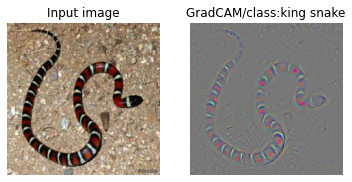

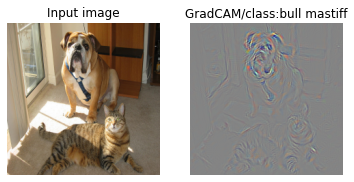

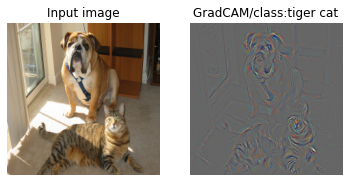

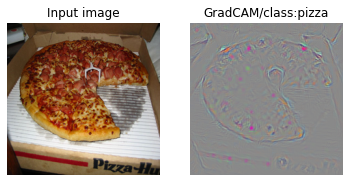

In [168]:
guided_backprop = GBackprop(model_AlexNet)

for i in range(len(test_list)):
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    fig = plt.figure()
    fig.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    fig.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(mask)
    plt.axis('off')

#### 2.VGGnet


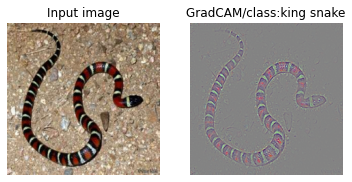

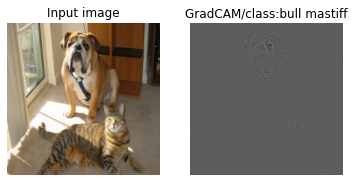

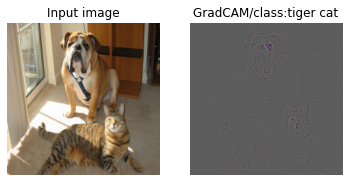

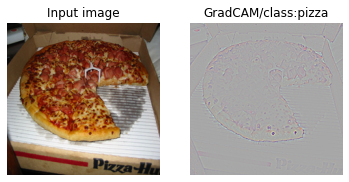

In [169]:
guided_backprop = GBackprop(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    gradient_numpy,mask = guided_backprop.gen_mask(img, one_hot_target)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(mask)
    plt.axis('off')

### Guided Grad-CAM visualization

#### 1.AlexNet

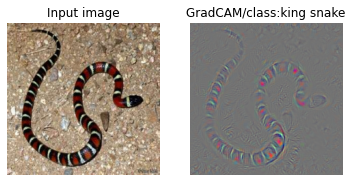

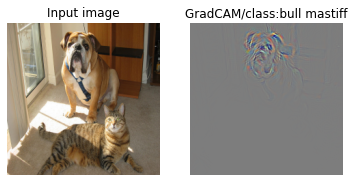

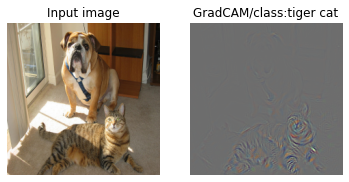

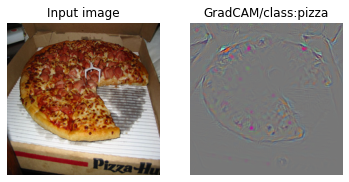

In [170]:
gradcam = GradCAM(model_AlexNet)
guided_backprop = GBackprop(model_AlexNet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)
    
    cam_img = gradcam.gen_CAM(img, one_hot_target)    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    guided_gradcam = np.multiply(cam_img, gradient_numpy).transpose(1,2,0)
    guided_gradcam = (guided_gradcam - np.min(guided_gradcam)) /\
            (np.max(guided_gradcam) - np.min(guided_gradcam) + 1e-08)
    
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(guided_gradcam)
    plt.axis('off')

#### 2. VGGnet

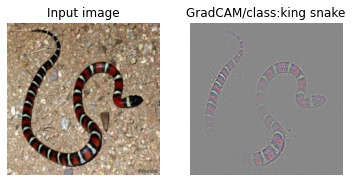

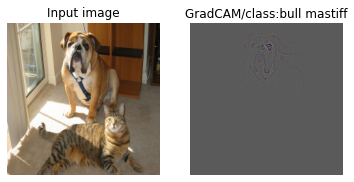

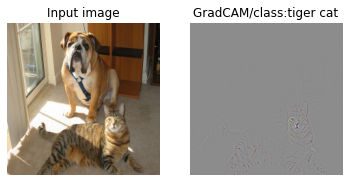

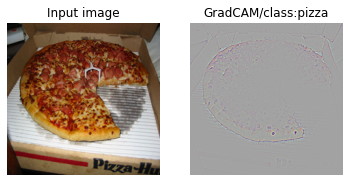

In [172]:
gradcam = GradCAM(model_VGGnet)
guided_backprop = GBackprop(model_VGGnet)

for i in range(len(test_list)):
    
    img_path = test_list[i][0]
    target_class = test_list[i][1]
    
    one_hot_target = torch.zeros([1, num_classes], dtype=torch.float)
    one_hot_target[0][target_class] = 1
    one_hot_target = one_hot_target.to(device)
    
    img_ = Image.open(img_path).convert('RGB')
    img = preprocess_image(img_)
    img = img.requires_grad_().to(device)

    cam_img = gradcam.gen_CAM(img, one_hot_target)    
    gradient_numpy, mask = guided_backprop.gen_mask(img, one_hot_target)

    guided_gradcam = np.multiply(cam_img, gradient_numpy).transpose(1,2,0)
    guided_gradcam = (guided_gradcam - np.min(guided_gradcam))/\
            (np.max(guided_gradcam) - np.min(guided_gradcam) + 1e-08)
  
    figure1 = plt.figure()
    figure1.add_subplot(1,2,1).set_title('Input image')
    imgplot = plt.imshow(reprocess_image(img))
    plt.axis('off')
    figure1.add_subplot(1,2,2).set_title('GradCAM/class:{}'.format(imagenet_class[target_class]))
    imgplot = plt.imshow(guided_gradcam)
    plt.axis('off')

### *References*
[1] https://arxiv.org/pdf/1610.02391.pdf <br>
[2] https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf <br>
[3] https://arxiv.org/pdf/1409.1556.pdf <br>
[4] https://bob3rdnewbie.tistory.com/320 <br>
[5] https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook <br>
[6] https://arxiv.org/pdf/1412.6806.pdf <br>
[7] https://arxiv.org/pdf/1311.2901.pdf <br>
[8] https://medium.com/@jamesvanneman/paper-club-visualizing-and-understanding-convolutional-networks-629fef9ceb8b <br>

## Discussion

이번 실험에서는 Grad-CAM을 구현하였다. Grad-CAM은 XAI의 한 종류로 CNN 네트워크에서 classification 등의 결과를 내렸을 때,
그 과정에서 실제로 네트워크가 input data(이미지)의 어떤 부분을 많이 참조해 그런 결과를 내렸는지 알려주는 모델이다.

Grad-CAM이 나오기 전 기존에는 CAM이라는 알고리즘이 있었다. CAM역시 heat map을 통해 CNN이 인식한 이미지의 부분들을 잘 알아냈지만
CAM의 경우 기존의 모델의 feature map에 global average pooling을 적용해야 한다는 점에서 그 사용이 제한적이라는 단점이 있었다.

Grad-CAM은 Global average pooling을 사용하는 대신 gradient로부터 정보를 추출해 CAM을 만들어 낸 알고리즘이다.


코드 구현 과정에서는 convolutional layer의 끝 부분에서 gradient와 feature map 등을 추출해야 했다.
이 때 pytorch의 register_backward_hook등의 함수를 사용해 이를 구현할 수 있었다.


구현한 Grad-CAM의 성능은 사진을 통해 확인할 수 있으며 모두 좋은 결과가 나오고 있는 것을 알 수 있다.